In [1]:
import torch
# from mobilevit import MobileViT
from torchvision.models.mobilenetv2 import MobileNetV2

model = MobileNetV2(width_mult=1.0).cuda()
state_dict = torch.load('/root/palmprint/output_mbfn_2023-11-30_00-11-08/mbfn_weights_epoch_40.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [2]:
# load validation set
with open('/root/autodl-tmp/verification/ROI/validation.txt') as f:
    lines = f.readlines()

images = [line.rstrip('\n') for line in lines]

# sort images based on their labels
sorted_images = sorted(images, key=lambda s : (int(s[:3]), s[8]))

labels = [(int(img[:3])-1) * 2 + int(img[8] == 'r') for img in sorted_images]

In [3]:
import os
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PalmValidationDataset(Dataset):
    def __init__(self, img_dir: str, img_list: list, transform=None):
        super(PalmValidationDataset, self).__init__()
        self.img_dir = img_dir
        self.images = img_list
        # self.labels = label_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.img_dir, img_file)
        image = Image.open(img_path)
        # label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = PalmValidationDataset(img_dir='/root/autodl-tmp/verification/ROI',
                                img_list=sorted_images,
                                transform=transform)

bs = 400
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=12)

feat_mat = torch.zeros(1600, 1280).cuda()  # (num_img, dim_feat)

for idx, image in enumerate(dataloader):
    image = image.cuda()
    with torch.no_grad():
        features = model(image)
        # features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        norm_feat = (features**2).sum(axis=1, keepdim=True).sqrt()
        features = features / norm_feat
        feat_mat[idx * bs : (idx + 1) * bs, :] = features


In [5]:
feat_mat

tensor([[-0.0435, -0.0121, -0.0048,  ..., -0.0154, -0.0084,  0.0455],
        [-0.0431, -0.0157, -0.0020,  ..., -0.0259,  0.0053,  0.0191],
        [-0.0455, -0.0144,  0.0023,  ..., -0.0364, -0.0075,  0.0250],
        ...,
        [-0.0216,  0.0272,  0.0311,  ..., -0.0072,  0.0140,  0.1765],
        [-0.0425, -0.0148,  0.0245,  ..., -0.0646,  0.0055,  0.0423],
        [-0.0597, -0.0184,  0.0066,  ..., -0.0667, -0.0087,  0.0445]],
       device='cuda:0')

In [7]:
# simlilarity matrix
sim_mat = feat_mat @ feat_mat.T

In [8]:
sim_mat

tensor([[ 1.0000,  0.9043,  0.8965,  ...,  0.0143,  0.0725,  0.0154],
        [ 0.9043,  1.0000,  0.9749,  ..., -0.0420,  0.0754,  0.0233],
        [ 0.8965,  0.9749,  1.0000,  ..., -0.0248,  0.0774,  0.0242],
        ...,
        [ 0.0143, -0.0420, -0.0248,  ...,  1.0000,  0.5240,  0.4860],
        [ 0.0725,  0.0754,  0.0774,  ...,  0.5240,  1.0000,  0.7706],
        [ 0.0154,  0.0233,  0.0242,  ...,  0.4860,  0.7706,  1.0000]],
       device='cuda:0')

In [9]:
# ground truth matrix
gt = torch.zeros(1600, 1600, dtype=int).cuda()
for i in range(40):
    gt[i * 40 : (i + 1) * 40, i * 40 : (i + 1) * 40] = 1

In [10]:
gt

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], device='cuda:0')

In [11]:
def test_threshold(sim_mat, gt, img_per_id, step=0.01, t_min=0, t_max=1):
    acc_list = []
    far_list = []    # false acceptance rate
    tpr_list = []    # true positive rate
    
    num_img = gt.shape[0]
    num_id = num_img / img_per_id

    t = t_min    # threshold
    eer = 0  # equal error rate
    min_diff = 1
    while t < t_max:
        predict = sim_mat > t
        correct = predict == gt
        num_true_positive = (predict * gt).sum()
        num_false_positive = (predict * (1 - gt)).sum()
        acc = correct.sum() / (num_img * num_img)
        tpr = (num_true_positive - num_img) / (img_per_id * num_img - num_img)
        far = num_false_positive / (num_img * num_img - img_per_id * img_per_id * num_id)
        if abs(1 - tpr - far) < min_diff:
            eer = (far + 1 - tpr) / 2
            min_diff = abs(1 - tpr - far)
        print(f't = {t:.3f}, acc = {acc:.4f}, tpr = {tpr:.4f}, far = {far:.5f}')
        acc_list.append(acc)
        far_list.append(far)
        tpr_list.append(tpr)
        t += step
    return eer

In [12]:
# If we view left and right hands as different identity
eer = test_threshold(sim_mat, gt, 40, step=0.001, t_max=0.5)
print(f'EER = {eer: .5f}')

t = 0.000, acc = 0.4800, tpr = 0.9975, far = 0.53327
t = 0.001, acc = 0.4847, tpr = 0.9974, far = 0.52846
t = 0.002, acc = 0.4892, tpr = 0.9974, far = 0.52381
t = 0.003, acc = 0.4939, tpr = 0.9973, far = 0.51904
t = 0.004, acc = 0.4984, tpr = 0.9972, far = 0.51442
t = 0.005, acc = 0.5029, tpr = 0.9971, far = 0.50974
t = 0.006, acc = 0.5075, tpr = 0.9971, far = 0.50508
t = 0.007, acc = 0.5121, tpr = 0.9971, far = 0.50035
t = 0.008, acc = 0.5167, tpr = 0.9970, far = 0.49564
t = 0.009, acc = 0.5212, tpr = 0.9969, far = 0.49100
t = 0.010, acc = 0.5258, tpr = 0.9969, far = 0.48631
t = 0.011, acc = 0.5304, tpr = 0.9969, far = 0.48158
t = 0.012, acc = 0.5349, tpr = 0.9969, far = 0.47694
t = 0.013, acc = 0.5394, tpr = 0.9969, far = 0.47233
t = 0.014, acc = 0.5438, tpr = 0.9968, far = 0.46780
t = 0.015, acc = 0.5484, tpr = 0.9968, far = 0.46314
t = 0.016, acc = 0.5529, tpr = 0.9967, far = 0.45853
t = 0.017, acc = 0.5574, tpr = 0.9966, far = 0.45389
t = 0.018, acc = 0.5619, tpr = 0.9966, far = 0

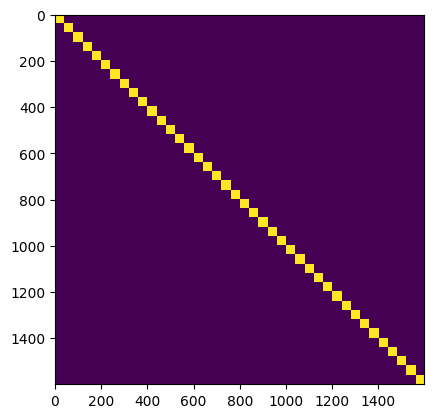

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(gt.cpu().numpy(), cmap='viridis', interpolation='nearest')

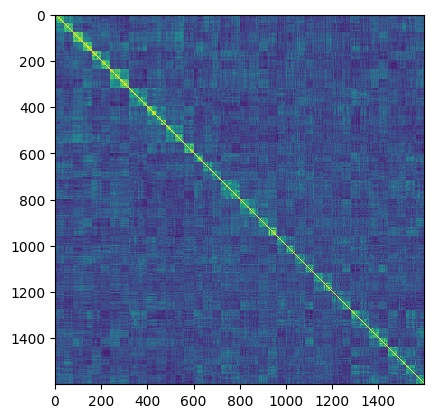

In [14]:
plt.imshow(sim_mat.cpu().numpy(), cmap='viridis', interpolation='nearest')

In [16]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,